In [1]:
import pandas as pd
import numpy as np

# EDA

In [2]:
df_sintatic = pd.read_pickle("data/synthetic_wemb_MiniLM_L6_v2.pkl")
df_ambiguous = pd.read_csv('data/ambiguous.csv')
df_not_ambiguous = pd.read_csv('data/not_ambiguous.csv')

In [3]:
df_sintatic.head()

,Sentence,Expansion,Acronym,Sentence_Emb,Expansion_Emb
600,Managing AR is crucial for maintaining a healt...,Accounts Receivable,AR,"[[-0.043010436, 0.030251851, -0.4291916, -0.00...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
603,Effective AR management reduces the risk of ba...,Accounts Receivable,AR,"[[-0.07896995, 0.22533315, -0.024554426, -0.20...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
604,Timely follow-ups with customers can speed up ...,Accounts Receivable,AR,"[[-0.14787723, -0.34664398, -0.7436014, -0.067...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
605,AR software automates invoice generation and p...,Accounts Receivable,AR,"[[-0.3722177, -0.23643449, -0.63709235, -0.106...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
606,Accurate AR records are essential for financia...,Accounts Receivable,AR,"[[-0.34439862, -0.46760595, -0.5512057, 0.2068...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."


In [4]:
df_ambiguous.head()

,sentence,acronyms,expansions,expanded
0,"The HR team is responsible for recruitment, tr...",HR,Human Resources,The Human Resources team is responsible for re...
1,"Reporting to the HR Director, the HR Manager w...",HR,Human Resources,"Reporting to the Human Resources Director, the..."
2,We need to ensure we continue to stay complian...,HR,Human Resources,We need to ensure we continue to stay complian...
3,Our HR department has taken steps to introduce...,HR,Human Resources,Our Human Resources department has taken steps...
4,The HR manager is leading a series of stakehol...,HR,Human Resources,The Human Resources manager is leading a serie...


In [5]:
df_not_ambiguous.head()

,sentence,acronyms,type,expansions,expanded
0,"The HR team is responsible for recruitment, tr...",HR,Simple,Human Resources,The Human Resources team is responsible for re...
1,"Reporting to the HR Director, the HR Manager w...",HR,Simple,Human Resources,"Reporting to the Human Resources Director, the..."
2,We need to ensure we continue to stay complian...,HR,Simple,Human Resources,We need to ensure we continue to stay complian...
3,Our HR department has taken steps to introduce...,HR,Simple,Human Resources,Our Human Resources department has taken steps...
4,The HR manager is leading a series of stakehol...,HR,Simple,Human Resources,The Human Resources manager is leading a serie...


# Disambiguation 

In [6]:
from disambiguation import embedding_based_only, jaccard_based

results_embedding = {
    "True": [],
    "Label": [],
    "Prediction": []
}

results_embedding = embedding_based_only(df_sintatic, results_embedding)
results_df = pd.DataFrame(results_embedding)

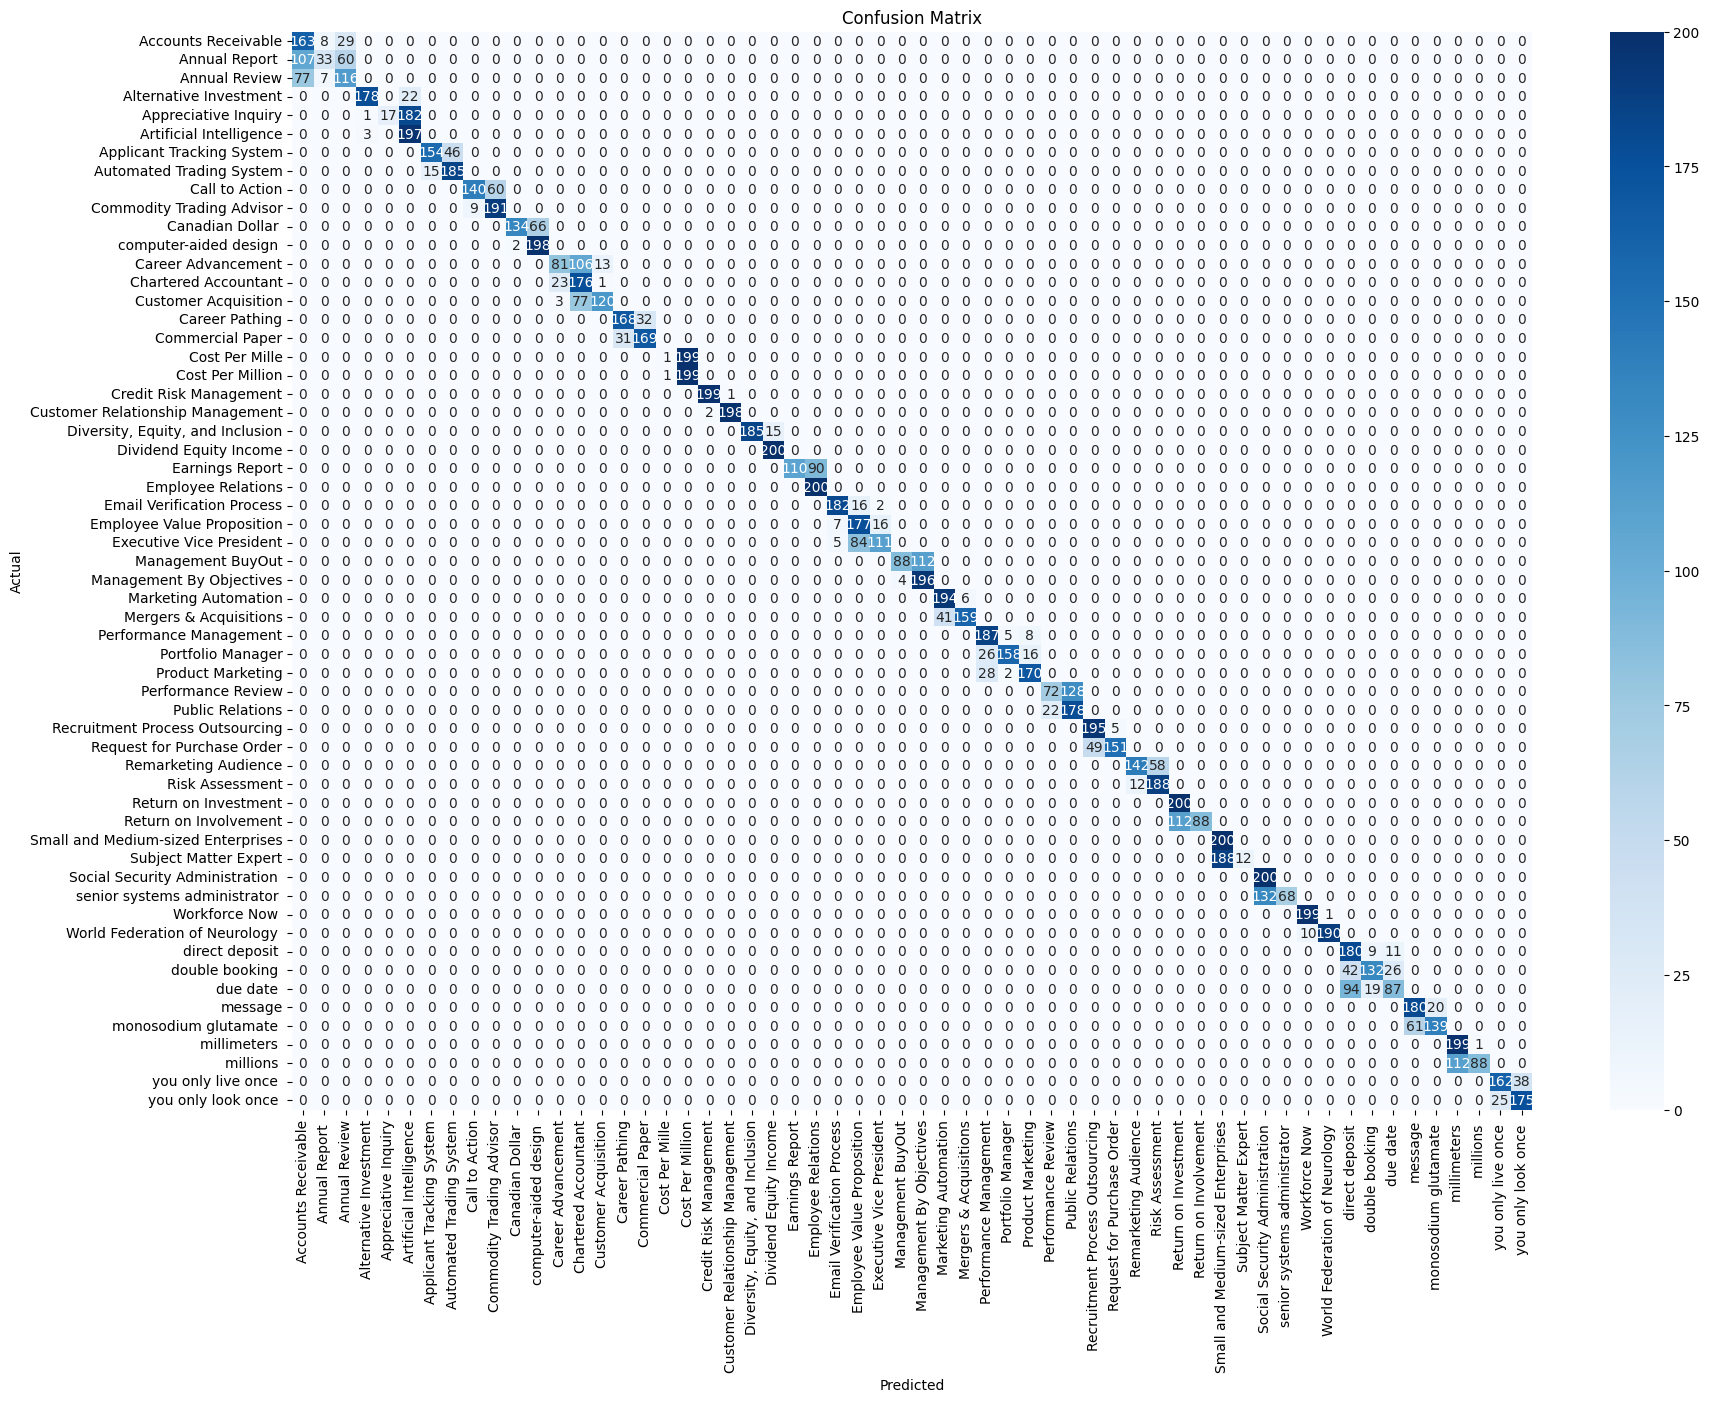

In [7]:
from sklearn.metrics import confusion_matrix, precision_score
from utils import plot_cfm

confusion = confusion_matrix(results_df['Label'], results_df['Prediction'], labels=results_df['Label'].unique())
plot_cfm(confusion, results_df)

In [8]:
(results_df["True"].sum() / len(results_df)) * 100

75.50862068965517

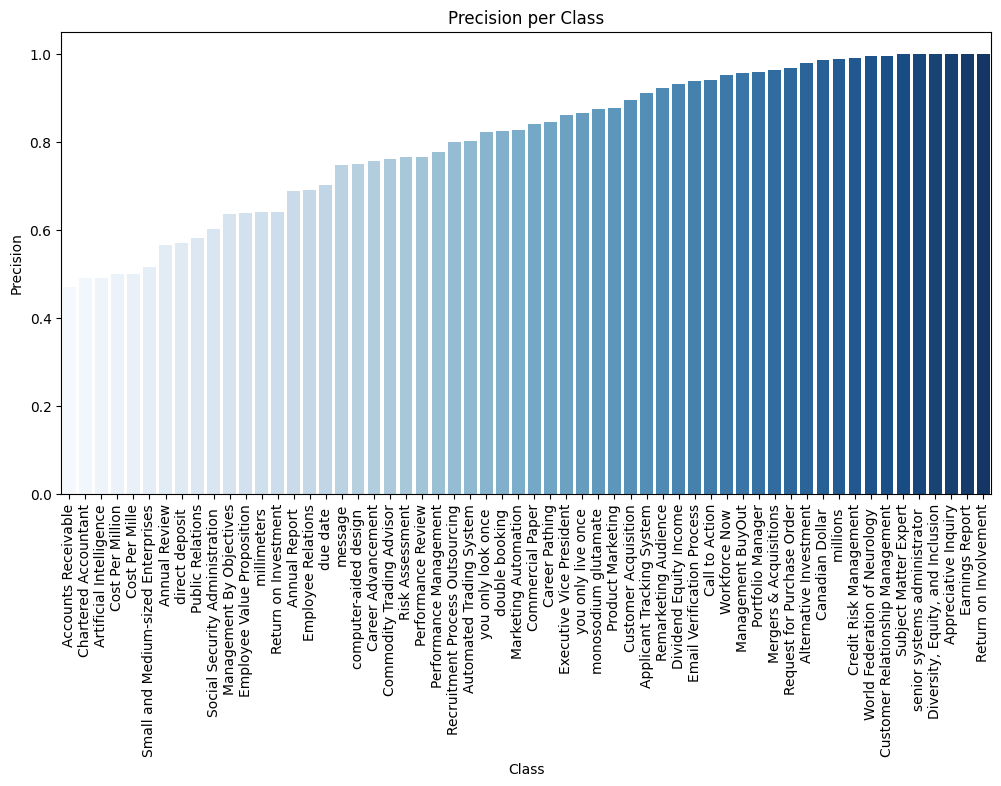

In [9]:
import matplotlib.pyplot as plt
from utils import plot_bar
from sklearn.metrics import precision_score

class_labels = results_df['Label'].unique()
precisions = []

for label in class_labels:
    true_labels = results_df['Label'] == label
    predicted_labels = results_df['Prediction'] == label
    precision = precision_score(true_labels, predicted_labels)
    precisions.append(precision)

precision_df = pd.DataFrame({'Class': class_labels, 'Precision': precisions})
precision_df = precision_df.sort_values(by='Precision', ascending=True)
plot_bar(precision_df)

# Single Inference

In [10]:
from utils import pprint
pprint(df_not_ambiguous, 5)

Sentence    Expansion
----------  -----------
Investors should track the NAV of their funds frequently to maximize returns.  Net Asset Value
The ability to use LIFO may depend heavily on specific industry regulations.  Last In, First Out
We should work towards creating a unique customer experience to boost CLV.  Customer Lifetime Value
The CAGR of the index was 7% in the last financial year.  Compound Annual Growth Rate
Our marketing team leverages CRO to optimize our webpage design and content.  Conversion Rate Optimization


In [21]:
string = 'AI is the simulation of human intelligence processes by machines.'

In [24]:
from disambiguation import single_inference
print(single_inference(string))

Artificial Intelligence
AI is the simulation of human intelligence processes by machines.


# Future Work

In [18]:
def calculate_precisions(results_df):
    unique_labels = results_df["Label"].unique()
    precisions = []
    for label in unique_labels:
        true_labels = results_df['Label'] == label
        predicted_labels = results_df['Prediction'] == label
        precision = precision_score(true_labels, predicted_labels)
        precisions.append(precision)
    return unique_labels, precisions

def filter_low_precision_classes(results_df, precisions, threshold=0.70):
    low_precision_classes = [label for label, precision in zip(unique_labels, precisions) if precision >= threshold]
    return results_df[~results_df['Label'].isin(low_precision_classes)]

unique_labels, precisions = calculate_precisions(results_df)
filtered_results_df = filter_low_precision_classes(results_df, precisions, threshold=0.60)

for i, acc_l in enumerate(filtered_results_df["Label"].unique()):
    precision = precisions[list(unique_labels).index(acc_l)]
    print(f"{i+1}. {acc_l}, {precision:.2f}")

1. Accounts Receivable, 0.47
2. Annual Review, 0.57
3. Artificial Intelligence, 0.49
4. Chartered Accountant, 0.49
5. Cost Per Mille, 0.50
6. Cost Per Million, 0.50
7. Public Relations, 0.58
8. Small and Medium-sized Enterprises, 0.52
9. direct deposit , 0.57


In [23]:
filtered_results_df

,True,Label,Prediction
0,True,Accounts Receivable,Accounts Receivable
1,True,Accounts Receivable,Accounts Receivable
2,True,Accounts Receivable,Accounts Receivable
3,True,Accounts Receivable,Accounts Receivable
4,True,Accounts Receivable,Accounts Receivable
...,...,...,...
9995,True,direct deposit,direct deposit
9996,True,direct deposit,direct deposit
9997,False,direct deposit,due date
9998,True,direct deposit,direct deposit
